In [10]:
# Initialize Otter
import otter
grader = otter.Notebook("lab12.ipynb")

# Lab 12: Logistic Regression

### Due Date

This assignment is due on **Tuesday, April 17, at 11:59PM PDT**

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.


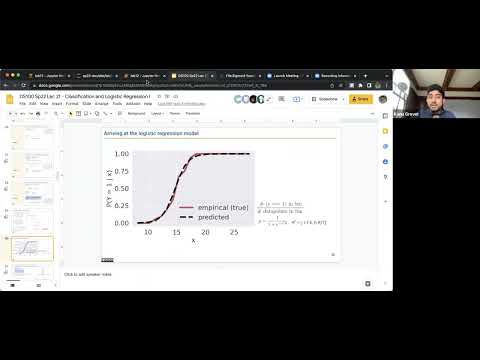

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("h-ujdXNc39Y", list = 'PLQCcNQgUcDfpRVLef61z2T1CAepOO0Ggz', listType = 'playlist')

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

In [2]:
# Run this cell to set up your notebook
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff


%matplotlib inline
sns.set()
sns.set_context("talk")

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Objectives

In Questions 1 and 2 of this lab, we will manually construct the logistic regression model and minimize cross-entropy loss using `scipy.minimize`. This structure mirrors the linear regression labs from earlier in the semester and lets us dive deep into how logistic regression works.

Lastly, in Question 3 we introduce the `sklearn.linear_model.LogisticRegression` module that you would use in practice, and we explore performance metrics for classification.

<br/><br/>

We will explore a breast cancer dataset from the University of Wisconsin ([source](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))). This dataset can be loaded using the `sklearn.datasets.load_breast_cancer()` method.  

In [3]:
# just run this cell
data = sklearn.datasets.load_breast_cancer()

# data is actually a dictionnary
print(data.keys())
print(data.DESCR)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these 

<br/>

Since the data format is a dictionary, we do some preprocessing to create a `pandas.DataFrame`.

In [4]:
# just run this cell
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The prediction task for this data is to predict whether a tumor is benign or malignant (a binary decision) given characteristics of that tumor. As a classic machine learning dataset, the prediction task is captured by the field `data.target`. To put the data back in its original context we will create a new column called `"malignant"` which will be 1 if the tumor is malignant and 0 if it is benign (reversing the definition of `target`).

In this lab, we will fit a simple **classification model** to predict breast cancer from the cell nuclei of a breast mass. For simplicity, we will work with only one feature: the `mean radius` which corresponds to the size of the tumor. Our output (i.e., response) is the `malignant` column.

In [5]:
# just run this cell

# Target data_dict['target'] = 0 is malignant 1 is benign
df['malignant'] = (data.target == 0).astype(int)

# Define our features/design matrix X
X = df[["mean radius"]]
Y = df['malignant']

<br/>

Before we go further, we will split our dataset into training and testing data. This lets us explore the prediction power of our trained classifier on both seen and unseen data.

In [6]:
# just run this cell
# Create a 75-25 train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
print(f"Training Data Size: {len(X_train)}")
print(f"Test Data Size: {len(X_test)}")

Training Data Size: 426
Test Data Size: 143


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 1: Defining the Model

In these first two parts, you will manually build a logistic regression classifier.

Recall that the Logistic Regression model is written as follows:

$$\Large f_{\theta}(x) = \sigma ( x^T \theta)$$

where $f_{\theta}(x)= P(Y=1 | x)$ is the probability that our observation belongs to class 1, and $\sigma$ is the sigmoid activation function:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

If we have a single feature, then $x$ is a scalar and our model has parameters $\theta = (\theta_0, \theta_1)$ as follows:

$$\Large f_{\theta}(x) = \sigma (\theta_0 + \theta_1 x)$$

Therefore just like OLS, if we have $n$ datapoints and $p$ features, then we can construct the design matrix
$$\mathbb{X} \in \mathbb{R}^{n \times (p + 1)}$$
with an all-ones column. Run the below cell to construct `X_intercept_train`. The syntax should look familiar:

In [7]:
# just run this cell
def add_bias_column(X):
    return np.hstack([np.ones((len(X), 1)), X])

X_intercept_train = add_bias_column(X_train)
X_intercept_train.shape

(426, 2)

<br/>

<hr style="border: 1px solid #fdb515;" />

## Question 1

### Question 1a

Using the above definition for $\mathbb{X}$, we can also construct a matrix representation of our Logistic Regression model, just like we did for OLS. Noting that $\theta = (\theta_0, \theta_1, \dots, \theta_p$), the vector $\hat{\mathbb{Y}}$ is:

$$\Large \hat{\mathbb{Y}} = \sigma(\mathbb{X} \theta) $$

Then the $i$-th element of $\hat{\mathbb{Y}}$ is the probability that the $i$-th observation belongs to class 1, given the feature vector is the $i$-th row of design matrix $\mathbb{X}$ and the parameter vector is $\theta$.

Below, implement the `lr_model` function to evaluate this expression. You should use `@` or `np.dot`.


<!--
BEGIN QUESTION
name: q1a
-->

In [8]:
def sigmoid(z):
    """
    The sigmoid function, defined for you
    """
    return 1 / (1 + np.exp(-z))

def lr_model(theta, X):
    """
    Return the logistic regression model as defined above.
    You should not need to use a for loop; use @ or np.dot.
    
    Args:
        theta: The model parameters. Dimension (p+1,).
        X: The design matrix. Dimension (n, p+1).
    
    Return:
        Probabilities that Y = 1 for each datapoint.
        Dimension (n,).
    """
    return sigmoid(X @ theta)

In [11]:
grader.check("q1a")

q1a results: All test cases passed!

<br/><br/>

---

###  Question 1b: Compute Empirical Risk
Now let's try to analyze the cross-entropy loss from logistic regression. Suppose for a single observation, we predict probability $p$ that the true response $y$ is in class 1 (otherwise the prediction is 0 with probability $1 - p$). The cross-entropy loss is:

$$ - \left( y \log(p) + (1 - y) \log(1 - p) \right)$$

For the logistic regression model, the **empirical risk** is therefore defined as the average cross-entropy loss across all $n$ datapoints:

$$\Large R(\theta) = -\frac{1}{n} \sum_{i=1}^n \left( y_i \log(\sigma(X_i^T \theta)) + (1 - y_i) \log(1 - \sigma(X_i^T \theta))  \right) $$

Where $y_i$ is the $i-$th response in our dataset, $\theta$ are the parameters of our model, $X_i$ is the i'th row of our design matrix $\mathbb{X}$, and $\sigma(X_i^T \theta)$ is the probability that the response is 1 given input $X_i$.

**Note**: In this class, when performing linear algebra operations we interpret both rows and columns as column vectors. So if we wish to calculate the dot product between row $X_i$ and a vector $v$, we write $X_i^Tv$.

Below, implement the function `lr_loss` that computes empirical risk over the dataset. Feel free to use functions defined in the previous part.

In [19]:
def lr_avg_loss(theta, X, Y):
    '''
    Compute the average cross entropy loss using X, Y, and theta.
    You should not need to use a for loop. 

    Args:
        theta: The model parameters. Dimension (p+1,)
        X: The design matrix. Dimension (n, p+1).
        Y: The label. Dimension (n,).

    Return:
        The average cross entropy loss.
    '''
    return - np.sum(Y @ np.log(sigmoid(X @ theta)) + (1 - Y) @ np.log(1 - sigmoid(X @ theta))) / X.shape[0]

In [20]:
grader.check("q1b")

q1b results: All test cases passed!

<br/><br/>

Below is a plot showing the average training cross-entropy loss for various values of $\theta_0$ and $\theta_1$ (respectively x and y in the plot).

In [22]:
# just run this cell
with np.errstate(invalid='ignore', divide='ignore'):
    uvalues = np.linspace(-8,8,70)
    vvalues = np.linspace(-5,5,70)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))
    lr_avg_loss_values = np.array([lr_avg_loss(t, X_intercept_train, Y_train) for t in thetas.T])
    lr_loss_surface = go.Surface(name="Logistic Regression Loss",
            x=u, y=v, z=np.reshape(lr_avg_loss_values,(len(uvalues), len(vvalues))),
            contours=dict(z=dict(show=True, color="gray", project=dict(z=True)))
        )
    fig = go.Figure(data=[lr_loss_surface])
    fig.update_layout(
        scene = dict(
            xaxis_title='theta_0',
            yaxis_title='theta_1',
            zaxis_title='Loss'),
            width=700,
            margin=dict(r=20, l=10, b=10, t=10))
    py.iplot(fig)

In [23]:
with np.errstate(invalid='ignore', divide='ignore'):
    uvalues = np.linspace(-8,8,70)
    vvalues = np.linspace(-5,5,70)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))
    lr_loss_values = np.array([lr_avg_loss(t, X_intercept_train, Y_train) for t in thetas.T])
    lr_loss_surface = go.Surface(name="Logistic Regression Loss",
            x=u, y=v, z=np.reshape(lr_loss_values,(len(uvalues), len(vvalues))),
            contours=dict(z=dict(show=True, color="gray", project=dict(z=True)))
        )
    fig = go.Figure(data=[lr_loss_surface])
    # fig.update_layout(
    #     scene = dict(
    #         xaxis_title='theta_1',
    #         yaxis_title='theta_2',
    #         zaxis_title='Loss'),
    #         width=700,
    #         margin=dict(r=20, l=10, b=10, t=10))
    py.iplot(fig)

<br/>

---

### Question 1c
Describe one interesting observation about the loss plot above.

<!--
BEGIN QUESTION
name: q1c
-->

It's convex, which is a nice property to have.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 2: Fit and Predict

### [Tutorial] `scipy.optimize.minimize`

The next two cells call the `minimize` function from `scipy` on the `lr_avg_loss` function you defined in the previous part. We pass in the training data to `args` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)) to find the `theta_hat` that minimizes the average cross-entropy loss over the train set.

In [24]:
# just run this cell
from scipy.optimize import minimize

min_result = minimize(lr_avg_loss,
                      x0=np.zeros(X_intercept_train.shape[1]),
                      args=(X_intercept_train, Y_train))
min_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.3123767645014974
        x: [-1.387e+01  9.372e-01]
      nit: 16
      jac: [-4.098e-07 -7.343e-06]
 hess_inv: [[ 7.480e+02 -5.213e+01]
            [-5.213e+01  3.684e+00]]
     nfev: 57
     njev: 19

In [25]:
# just run this cell
theta_hat = min_result['x']
theta_hat

array([-13.87178119,   0.93723879])

<br/>

Because our design matrix $\mathbb{X}$ leads with a column of all ones, `theta_hat` has two elements: $\hat{\theta}_0$ is the estimate of the intercept/bias term, and $\hat{\theta}_1$ is the estimate of the slope of our single feature.

<br/><br/>

It's time for a recap:
* For logistic regression with parameter $\theta$, $P(Y = 1 | x) = \sigma(x^T \theta)$, where $\sigma$ is the sigmoid function and $x$ is a feature vector. Therefore $\sigma(x^T \theta)$ is the Bernoulli probability that the response is 1 given the feature is $x$ Otherwise the response is 0 with probability $P(Y = 0 | x) = 1 - \sigma(x^T \theta)$.
* The $\hat{\theta}$ that *minimizes* average log-entropy loss of our training data also *maximizes* the likelihood of observing the training data according to the logistic regression model (check out lecture for more details).

The main takeaway is that logistic regression models **probabilities** of classifying datapoints as 1 or 0. Next, we use this takeaway to implement model predictions.

<br/>

<hr style="border: 1px solid #fdb515;" />

## Question 2

Using the `theta_hat` estimate above, we can construct a **decision rule** for classifying a datapoint with observation $x$. Let $P(Y = 1 | x) = \sigma(x^T \hat{\theta})$:



$$\Large \text{classify}(x) = \begin{cases} 1, & P(Y = 1 | x) \geq 0.5 \\ 0, & P(Y = 1 | x) < 0.5 \end{cases}$$

This decision rule has a decision **threshold** $T = 0.5$. This threshold means that we treat the classes $0$ and $1$ "equally." Lower thresholds mean that we are more likely to predict $1$, whereas higher thersholds mean that we are more likely to predict $0$.

<br/>

Implement the `lr_predict` function below, which returns a vector of predictions according to the logistic regression model. The function  takes a design matrix of observations `X`, parameter estimate `theta`, and decision threshold `threshold` with default value 0.5.


<!--
BEGIN QUESTION
name: q2
-->

In [26]:
def lr_predict(theta, X, threshold=0.5):
    '''
    Classification using a logistic regression model
    with a probability threshold.

    Args:
        theta: The model parameters. Dimension (p+1,)
        X: The design matrix. Dimension (n, p+1).
        threshold: decision rule threshold for predicting class 1.

    Return:
        A vector of predictions.
    '''
    return (sigmoid(X @ theta) > 0.5).astype(int)

# do not modify below this line
Y_train_pred = lr_predict(theta_hat, X_intercept_train)
Y_train_pred

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,

In [27]:
grader.check("q2")

q2 results: All test cases passed!

<br/><br/>

### [Tutorial] Linearly separable data

How do these predicted classifications compare to the true responses $\mathbb{Y}$?

Run the below cell to visualize our predicted responses, the true responses, and the probabilities we used to make predictions. We use `sns.stripplot` which introduces some jitter to avoid overplotting.

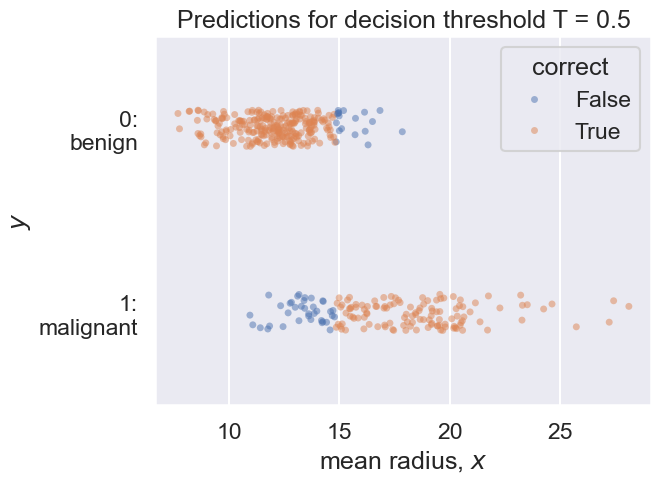

In [28]:
# just run this cell
plot_df = pd.DataFrame({"X": np.squeeze(X_train),
                        "Y": Y_train,
                        "Y_pred": Y_train_pred,
                        "correct": (Y_train == Y_train_pred)})
sns.stripplot(data=plot_df, x="X", y="Y", orient='h', alpha=0.5, hue="correct")
plt.xlabel('mean radius, $x$')
plt.ylabel('$y$')
plt.yticks(ticks=[0, 1], labels=['0:\nbenign', '1:\nmalignant'])
plt.title("Predictions for decision threshold T = 0.5")
plt.show()

<br/>

Because we are using a decision threshold $T = 0.5$, we predict $1$ for all $x$ where $\sigma(x^T\theta) \geq 0.5$, which happens when $x^T\theta = 0$. For the single mean radius feature, we can use algebra to solve for the boundary to be approximately $x \approx 14.8$.

In other words, will always predict $0$ (benign) if the mean radius feature is less than 14.8, and $1$ (malignant) otherwise. However, in our training data there are datapoints with large mean radii that are benign, and vice versa. Our data is not **linearly separable** by a vertical line.

The above visualization is useful when we have just one feature. In practice, however, we use other performance metrics to diagnose our model performance. Next, we will explore several such metrics: accuracy, precision, recall, and confusion matrices.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 3: Quantifying Performance



### [Tutorial] sklearn's `LogisticRegression`
Instead of using the model structure we built manually in the previous questions, we will instead use sklearn's `LogisticRegression` model, which operates similarly to the sklearn OLS, Ridge, and LASSO models.

Let's first fit a logistic regression model to the training data. Some notes: 
* Like with linear models, the `fit_intercept` argument specifies if model includes an intercept term. We therefore pass in the original matrix `X_train` in the call to `lr.fit()`.
* sklearn fits a **regularized** logistic regression model as specified by the `solver='lbfgs'` argument; read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for more details.

In [29]:
# just run this cell
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
        fit_intercept=True,
        solver = 'lbfgs')

lr.fit(X_train, Y_train)
lr.intercept_, lr.coef_

(array([-13.75289919]), array([[0.92881284]]))

<br/>

Note that because we are now fitting a regularized logistic regression model, the estimated coefficients above deviate slightly from our numerical findings in Question 1.

<br/>

Like with linear models, we can call `lr.predict(x_train)` to classify our training data with our fitted model.

In [30]:
# just run this cell
lr.predict(X_train)

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,

Note that for a binary classification task, the sklearn model uses an unadjustable decision rule of 0.5. If you're interested in manually adjusting this threshold, check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for `lr.predict_proba()`.

<br/>

<hr style="border: 1px solid #fdb515;" />

## Question 3

### Question 3a: Accuracy

Fill in the code below to compute the training and testing accuracy, defined as:

$$
\text{Training Accuracy} = \frac{1}{n_{train\_set}} \sum_{i \in {train\_set}} {\mathbb{1}_{y_i == \hat{y_i}}}
$$

$$
\text{Testing Accuracy} = \frac{1}{n_{test\_set}} \sum_{i \in {test\_set}} {\mathbb{1}_{y_i == \hat{y_i}}}
$$

where for the $i$-th observation in the respective dataset, $\hat{y_i}$ is the predicted response and $y_i$ the true response.  $\mathbb{1}_{y_i == \hat{y_i}}$ is an indicator function which is $1$ if ${y_i} = \hat{y_i}$ and $ 0$ otherwise.

<!--
BEGIN QUESTION
name: q3a
-->

In [37]:
train_accuracy = np.sum(lr.predict(X_train) == Y_train) / X_train.shape[0]
test_accuracy = np.sum(lr.predict(X_test) == Y_test) / X_test.shape[0]

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.8709
Test accuracy: 0.9091


In [38]:
grader.check("q3a")

q3a results: All test cases passed!

<br/>

---

### Question 3b: Precision and Recall

It seems we can get a very high test accuracy. What about precision and recall?  
- **Precision** (also called positive predictive value) is the fraction of true positives among the total number of data points predicted as positive.  
- **Recall** (also known as sensitivity) is the fraction of true positives among the total number of data points with positive labels.

Precision measures the ability of our classifier to not predict negative samples as positive (i.e., avoid false positives), while recall is the ability of the classifier to find all the positive samples (i.e., avoid false negatives).



Below is a graphical illustration of precision and recall, modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall):
![precision_recall](precision_recall.png)

Mathematically, Precision and Recall are defined as:
$$
\text{Precision} = \frac{n_{true\_positives}}{n_{true\_positives} + n_{false\_positives}}
$$

$$
\text{Recall} = \frac{n_{true\_positives}}{n_{true\_positives} + n_{false\_negatives}}
$$

Use the formulas above to compute the precision and recall for the **test set** using the `lr` model trained using sklearn.

<!--
BEGIN QUESTION
name: q3b
-->

In [55]:
Y_test_pred = lr.predict(X_test)
n_true_positive = np.sum(Y_test_pred == Y_test) - np.sum((~Y_test_pred[Y_test_pred == Y_test].astype(bool)).astype(int))

precision =  n_true_positive / np.sum(Y_test_pred)
recall = n_true_positive / np.sum(Y_test)

print(f'precision = {precision:.4f}')
print(f'recall = {recall:.4f}')

precision = 0.9184
recall = 0.8333


In [56]:
grader.check("q3b")

q3b results: All test cases passed!

<br/>

---

### Question 3c

Our precision is fairly high, while our recall is a bit lower.

Consider the following plots, which display the distribution of the **response variable** $\mathbb{Y}$ in the training and testing sets (sometimes called the target, or true response). Recall class labels are 0: benign, 1: malignant.

<!--
BEGIN QUESTION
name: q3c
-->

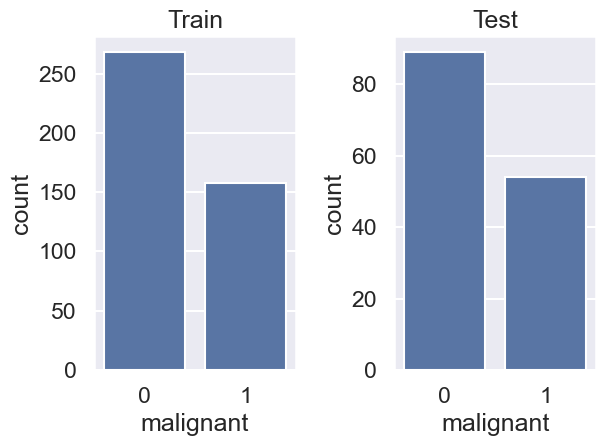

In [57]:
fig, axes = plt.subplots(1, 2)
sns.countplot(x=Y_train, ax=axes[0]);
sns.countplot(x=Y_test, ax=axes[1]);

axes[0].set_title('Train')
axes[1].set_title('Test')
plt.tight_layout();

Based on the above distribution, what might explain the observed difference between our precision and recall metrics?


<!--
BEGIN QUESTION
name: q3c
-->

_Type your answer here, replacing this text._

<br/><br/>

---

### [Tutorial] Confusion Matrices

To understand the link between precision and recall, it's useful to create a **confusion matrix** of our predictions. Luckily, `sklearn.metrics` provides us with such a function!

The `confusion_matrix` function ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)) categorizes counts of datapoints based if their true and predicted values match.

For the 143-datapoint test dataset:

In [58]:
# just run this cell
from sklearn.metrics import confusion_matrix

Y_test_pred = lr.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_test_pred)
cnf_matrix

array([[85,  4],
       [ 9, 45]])

We've implemented the following function to better visualize these four counts against the true and predicted categories:

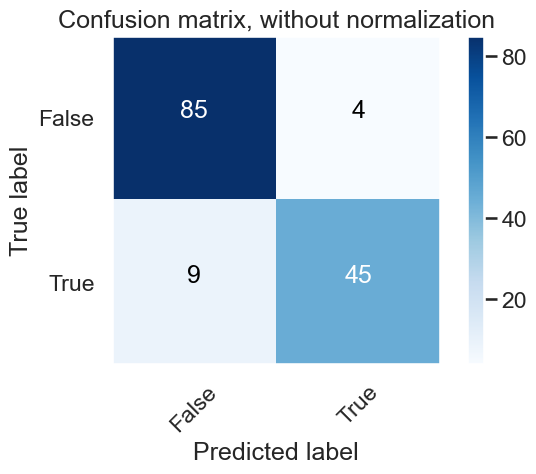

In [59]:
# just run this cell

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['False', 'True']

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


---

### Question 3d: Normalized Confusion Matrix

To better interpret these counts, assign `cnf_matrix_norm` to a **normalized confusion matrix** by the count of each true label category.

In other words, build a 2-D NumPy array constructed by normalizing `cnf_matrix` by the count of datapoints in each row. For example, the top-left quadrant of `cnf_matrix_norm` should represent the proportion of true negatives over the total number of datapoints with negative labels. 

**Hint**: In array broadcasting, you may encounter issues dividing 2-D NumPy arrays by 1-D NumPy arrays. Check out the `keepdims` parameter in `np.sum` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.sum.html)).

<!--
BEGIN QUESTION
name: q3d
-->

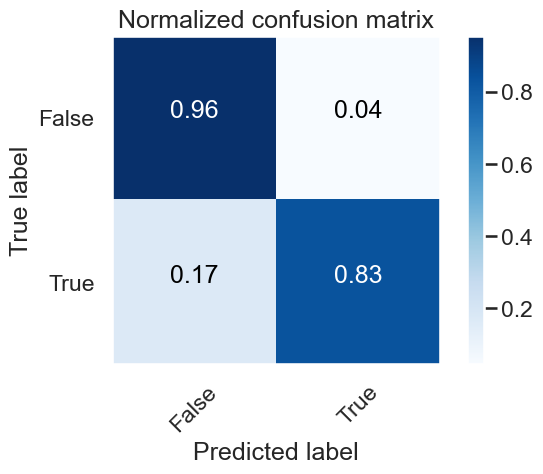

In [62]:
cnf_matrix_norm = cnf_matrix / np.sum(cnf_matrix, axis=1, keepdims=True)

# do not modify below this line
plot_confusion_matrix(cnf_matrix_norm, classes=class_names,
                       title='Normalized confusion matrix')

In [63]:
grader.check("q3d")

q3d results: All test cases passed!

<br/>

Compare the normalized confusion matrix to the values you computed for precision and recall earlier:

In [64]:
# just run this cell for your convenience
print(f'precision = {precision:.4f}')
print(f'recall = {recall:.4f}')

precision = 0.9184
recall = 0.8333


<br/>
Based on the definitions of precision and recall, why does only recall appear in the normalized confusion matrix? Why doesn't precision appear? (No answer required for this part; just something to think about.)

# Congratulations! You finished the lab!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)